In [1]:
import numpy as np
import random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### kernals 
def linear_kernal(x,y):
    z = np.dot(x.T, y)
    return z

def polynomial_kernel(x1, x2, p=2):
#def linear_kernal(x1,x2):
    p = 2
    return (np.dot(x1, x2) + 1) ** p

def rbf_kernel(x1, x2):
#def linear_kernal(x1,x2):
    sigma=1
    """Compute the RBF (Gaussian) kernel between two vectors."""
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

def objective(alpha):
    result = 0.5* np.dot(alpha, np.dot(alpha, p)) - np.sum(alpha)
    return result

def zerofun(alpha):
    return np.dot(alpha, t)

def compute_b(alpha, X, t, K):
    """
    - alpha: Optimal Lagrange multipliers (N,)
    - X: Training data points (N, D)
    - t: Target labels (-1 or 1) (N,)
    - K: Kernel matrix (N, N)
    """
    C = 10  # The regularization parameter
    support_vector_indices = np.where((alpha > 1e-5) & (alpha < C))[0]  # Find indices of support vectors
    s = support_vector_indices[0]  # Pick the first support vector
    # Compute b using the support vector
    b = np.sum(alpha * t * K[s,:]) - t[s]
    return b

def compute_ind(alpha, X, t, linear_kernal, b, s):
    #print(f"X shape: {X.shape}")  # Debug: Check shape of X
    #print(f"s shape: {s.shape}")  # Debug: Check shape of s
    """
    Compute the indicator function for a new data point s.
    Parameters:
    - alpha: Optimal Lagrange multipliers (N,)
    - X: Training data points (N, D)
    - t: Target labels (-1 or 1) (N,)
    - K: Kernel matrix (N, N)
    - b: Bias term
    - s: New data point (D,)
    Returns:
    - ind: Indicator value
    """
    kernel_values = np.array([linear_kernal(s, x) for x in X])
    ind = np.sum(alpha * t * kernel_values) - b
    return ind


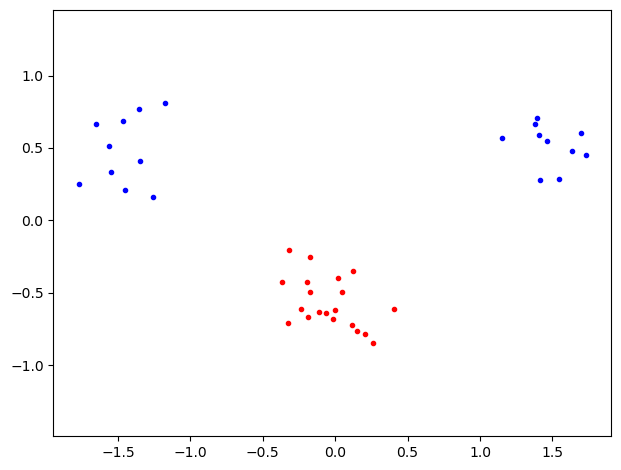

In [2]:
np.random.seed(100)
size_n = 10
classA = np.concatenate(
    (np.random.randn(size_n, 2) * 0.2 + [1.5, 0.5],
     np.random.randn(size_n, 2) * 0.2 + [-1.5, 0.5]) )
classB = np.random.randn(2*size_n, 2) * 0.2 + [0.0, -0.5]  # Number of rows (samples)

inputs = np.concatenate((classA, classB))
targets = np.concatenate(
    (np.ones(classA.shape[0]),
    -np.ones(classB.shape[0])))

N = inputs.shape[0]

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

plt.plot( [p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot( [p[0] for p in classB], [p[1] for p in classB], 'r.')

plt.tight_layout()
plt.axis('equal')
plt.savefig('svmplot.png')
plt.show()

In [3]:
t = targets
N = len(t) # t is the index
p = np.zeros((N,N))
x = inputs
C = 10
constraint={'type':'eq', 'fun':zerofun}
XC = constraint

## p matrix, p[i,j]=t[i]t[j]K(x[i],x[j])
for i in range(N):
    for j in range(N):
        p[i,j] = t[i]*t[j]*linear_kernal(x[i],x[j])
        
## K matrix, K[i,j]=kernal(x[i],x[j])        
K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = linear_kernal(x[i],x[j])
        
N = len(x)
start = np.zeros(N)
B = [(0, C) for _ in range(N) ]
#B = [(0, None) for _ in range(N) ]

ret = minimize(objective, start, bounds = B, constraints = XC)
alpha = ret['x']

b = compute_b(alpha, x, t, K)

# Extract non-zero alphas (support vectors)
support_vector_indices = np.where(alpha > 1e-5)[0]
support_vectors = x[support_vector_indices]
support_labels = t[support_vector_indices]
support_alphas = alpha[support_vector_indices]



In [4]:
print(alpha)

[0.00000000e+00 0.00000000e+00 2.93520019e-13 0.00000000e+00
 0.00000000e+00 6.93179175e+00 3.70001562e+00 0.00000000e+00
 0.00000000e+00 2.71099683e-15 3.08978482e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.07803410e-14 0.00000000e+00 0.00000000e+00 6.31807368e-01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.67411229e-13 0.00000000e+00
 3.03955665e-13 0.00000000e+00 1.61461669e-13 0.00000000e+00
 0.00000000e+00 2.31934755e-13 4.19051611e-15 0.00000000e+00
 7.52367089e-14 0.00000000e+00 3.05415024e-14 0.00000000e+00]


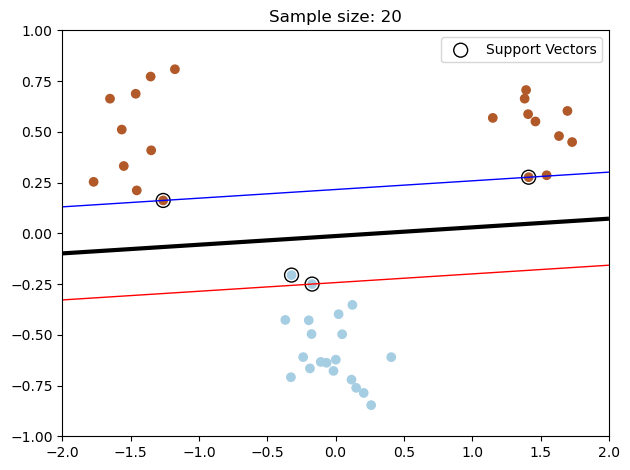

In [5]:
xgrid = np.linspace(-2,2)
ygrid = np.linspace(-1,1)

Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

x1 = x
grid = np.array([compute_ind(alpha, x1, t, linear_kernal, b, np.array([x, y])) for x, y in zip(np.ravel(Xgrid), np.ravel(Ygrid))])
grid = grid.reshape(Xgrid.shape)
plt.contour(Xgrid, Ygrid, grid, levels=[-1,0,1], colors=('red', 'black', 'blue'), linewidths=(1,3,1))

plt.scatter(x1[:, 0], x1[:, 1], c=t, cmap=plt.cm.Paired)

# Plot the support vectorx
support_vector_indices = np.where(alpha > 1e-5)[0]
plt.scatter(x1[support_vector_indices, 0], x1[support_vector_indices, 1], 
            s=100, facecolors='none', edgecolors='k', label='Support Vectors')
plt.title(f'Sample size: {size_n*2}')
plt.tight_layout()
plt.legend()
plt.savefig('size_10.png')
plt.show()
